In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# combines tensor and normalization transformations [0,1] -> [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

# testing set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

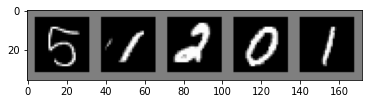

5     1     2     0     1    


In [3]:
# training set check
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
pad = nn.ZeroPad2d(2)
images = pad(images)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{:5s}'.format(classes[labels[j]]) for j in range(5)))

In [4]:
# Net() class definition w/ nn.Module inheritance
class Net(nn.Module):

  def __init__(self):
    # initializes inherited class (nn. Module)
    super(Net, self).__init__()
    # Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    # Linear(in_features, out_features)
    self.fc1 = nn.Linear(16 * 6 * 6, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    # pad 28x28 with zeros on all sides to make expected 32x32
    pad = nn.ZeroPad2d(2)
    x = pad(x)
    # "max pooling over a (2,2) window"
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    # "if the size is a square you can only specify a single number"
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = Net()
print(net)    

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [6]:
# training process
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get inputs - data is a list of [inputs, labels]
    inputs, labels = data
    # zero parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    # print results
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[{:d}, {:5d}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
    
print('Finished training!')

[1,  2000] loss: 1.558
[1,  4000] loss: 0.269
[1,  6000] loss: 0.152
[1,  8000] loss: 0.127
[1, 10000] loss: 0.104
[1, 12000] loss: 0.084
[2,  2000] loss: 0.079
[2,  4000] loss: 0.070
[2,  6000] loss: 0.065
[2,  8000] loss: 0.066
[2, 10000] loss: 0.061
[2, 12000] loss: 0.059
Finished training!


In [7]:
# save trained model
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

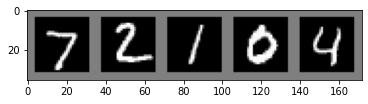

Ground truth:  7     2     1     0     4    
Predicted:     7     2     1     0     4    


In [8]:
# test set check
dataiter = iter(testloader)
images, labels = dataiter.next()
pad = nn.ZeroPad2d(2)
images_padded = pad(images)

imshow(torchvision.utils.make_grid(images_padded))
print('Ground truth: ', ' '.join('{:5s}'.format(classes[labels[j]]) for j in range(5)))

# show predicted values
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:    ', ' '.join('{:5s}'.format(classes[predicted[j]]) for j in range(5)))

In [10]:
# test evaluation
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(5):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

print('Overall accuracy: {:d}%\n'.format(int(100 * correct / total)))
for i in range(10):
  print('Accuracy of {:s} : {:2d}%'.format(classes[i], int(100 * class_correct[i] / class_total[i])))

Overall accuracy: 98%

Accuracy of 0 : 98%
Accuracy of 1 : 99%
Accuracy of 2 : 98%
Accuracy of 3 : 99%
Accuracy of 4 : 99%
Accuracy of 5 : 98%
Accuracy of 6 : 97%
Accuracy of 7 : 98%
Accuracy of 8 : 98%
Accuracy of 9 : 96%


## **RESULTS**

Overall accuracy: 98%

**Per category:**
- Accuracy of 0 : 98%
- Accuracy of 1 : 99%
- Accuracy of 2 : 98%
- Accuracy of 3 : 99%
- Accuracy of 4 : 99%
- Accuracy of 5 : 98%
- Accuracy of 6 : 97%
- Accuracy of 7 : 98%
- Accuracy of 8 : 98%
- Accuracy of 9 : 96%